Author: Licun Liu  
Student Id: 30901235  
Start date: 22/01/2021

# 1 Data Loading and exploration

## 1.1 Data Loading 
### 1.1.1 SparkContext and SparkSession <a class="anchor" name="one"></a>

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment_2"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "UTC")

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')

### 1.1.2 Define the data schema

In [2]:
# Library required
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql import functions as F

In [3]:
# Define the data schema for pedestrian count CSV files
schema_1 = StructType([StructField("ID",IntegerType(),True),
                     StructField("Date_Time",TimestampType(),True),
                      StructField("Year",IntegerType(),True),
                       StructField("Month",StringType(),True),
                        StructField("Mdate",IntegerType(),True),
                         StructField("Day",StringType(),True),
                          StructField("Time",IntegerType(),True),
                           StructField("Sensor_ID",IntegerType(),True),
                            StructField("Sensor_Name",StringType(),True),
                             StructField("Hourly_Counts",IntegerType(),True)])

# Define the data schema for the sensor location file
schema_2 = StructType([StructField("sensor_id",IntegerType(),True),
                     StructField("sensor_description",StringType(),True),
                      StructField("sensor_name",StringType(),True),
                       StructField("installation_date",DateType(),True),
                        StructField("status",StringType(),True),
                         StructField("note",StringType(),True),
                          StructField("direction_1",StringType(),True),
                           StructField("direction_2",StringType(),True),
                            StructField("latitude",FloatType(),True),
                             StructField("longitude",FloatType(),True),
                              StructField("location",StringType(),True)])                  

### 1.1.3 Load data into dataframe

In [4]:
# Load the pedestrian count CSV file into a dataframe
df1 = spark.read.csv('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv',timestampFormat = 'MM/dd/yyyy hh:mm:ss a',schema=schema_1,header=True)

# Load the sensor location CSV file into another dataframe
df2 = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv',dateFormat= 'yyyy/MM/dd' ,schema=schema_2,header=True)

In [5]:
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



In [6]:
df2.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



### 1.1.4 Create an additional column

In [7]:
# Using a function to return "above_threshold"
def somefunc(value):
    if value < 2000:
          return 0
    else:
          return 1
    
#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(somefunc, IntegerType())
# Call the function
df1 = df1.withColumn("above_threshold", udf_func("Hourly_Counts"))

## 1.2 Exploring the data    
### 1.2.1 Show the basic statistics

In [8]:
# Extract the numerical columns
numerical_col = [col.name for col in df1.schema.fields if isinstance(col.dataType, IntegerType)]
# Delete above_threshold column
numerical_col.remove("above_threshold")
# Show the basic statistics
df1[numerical_col].summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|               ID|              Year|             Mdate|              Time|         Sensor_ID|    Hourly_Counts|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          3435106|           3435106|           3435106|           3435106|           3435106|          3435106|
|   mean|        1717553.5|2016.0032330880038|15.751918863639142|11.459955238644746|22.978422791028866|560.7805942524044|
| stddev|991629.8312350252|3.1237869143646275|  8.79918757461428| 6.943473866829414|16.229792156265397|809.9942576353371|
|    min|                1|              2009|                 1|                 0|                 1|                0|
|    25%|           858830|              2014|                 8|                 5|                 9|               50|
|    50%|          17176

### 1.2.2 Show the basic statistics

In [9]:
df1.groupBy('above_threshold').count().show()

+---------------+-------+
|above_threshold|  count|
+---------------+-------+
|              1| 250942|
|              0|3184164|
+---------------+-------+



There are some class imbalances in the result. To be specific, nearly 250 thousand records above-threshold, and over 3.1 million records indicate the hourly pedestrian count below 2000.   
The reason behind this phenomenon may be pedestrians are concentrate in some specific areas, where records high hourly pedestrian count. However, in other traffic, pedestrians remain low.


### 1.2.3 Display a histogram

In [10]:
# Library Requried
import numpy as np
import pandas as pd
import math
from pyspark.sql.functions import *

##### 1 - Distribution of the hourly counts with log-scale for the frequency axis

In [11]:
# Dataframe prepare
df = df1.groupBy('Hourly_Counts').count().withColumn("count", log10(col("count"))).sort('Hourly_Counts').toPandas()

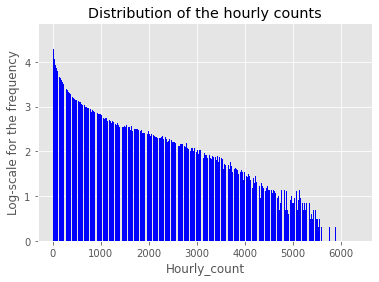

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot function
def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, y, color='blue')
    plt.xlabel("Hourly_count")
    plt.ylabel("Log-scale for the frequency")
    plt.title("Distribution of the hourly counts")
 #  plt.xticks(x_pos, x)
    plt.show()

# Call the function
plot_metrics(df["Hourly_Counts"],df["count"])

In this histogram, we use hourly pedestrian count as x-axis and log-scale for the frequency as the y-axis.  

From this plot, we find that the hourly_count values are concentrated on the lower hourly pedestrian count. As this value increases, its frequency becomes smaller and smaller.    

To be specific, when the hourly pedestrian counts less than 500, the log-scale for the frequency is over 3 and decreases below 1 as the hourly count larger than 5000.


##### 2 - The trend of the average daily count change by month

In [13]:
# Group by year and calculate day_count and sum hour
df1_group = df1.groupBy("Year","Month").agg(countDistinct("Year","Month","Mdate").alias("day_count"),sum("Hourly_Counts").alias("total_pedestrian_count"))

# Calculate average daily pedestrian counts and select some columns
df_result = df1_group.select(df1_group.Year, df1_group.Month, df1_group.total_pedestrian_count, 
                                df1_group.total_pedestrian_count/df1_group.day_count)

# Rename the column name and order by year
df_result = df_result.select(col("Year"),col("Month"), col("(total_pedestrian_count / day_count)").alias("average_daily_pedestrian_count"))


In [14]:
# Create a dictionary to store month value
months = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9, "October":10, "November":11, "December":12 }

# A function to covert month to numerical
def month_value(date):
    return months[date]

#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(month_value, IntegerType())
# Call the function
df = df_result.withColumn("Month_no", udf_func("Month")).orderBy("Year","Month_no")


In [15]:
# A function to combine year and month
def func(year,month):
    
    return (str(year) + "-" + str(month))

#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(func, StringType())
# Call the function
df = df.withColumn("date", udf_func("Year","Month_no")).toPandas()

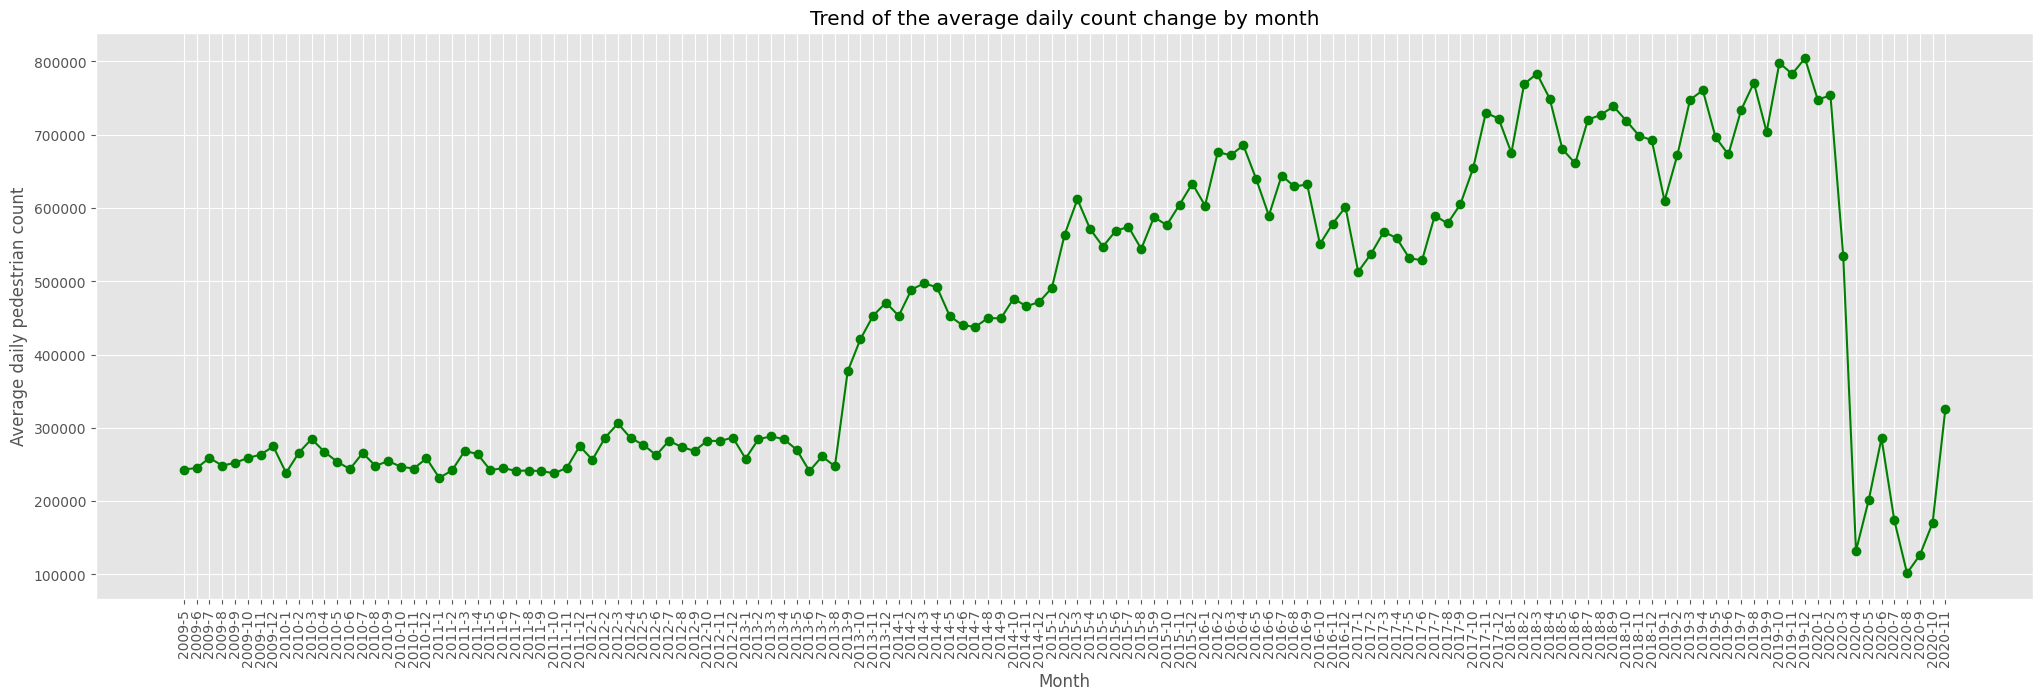

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator

# Draw a line chart
%matplotlib inline
def plot_metrics(x,y):
    plt.figure(figsize=(25, 7.5), dpi=100)
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.plot(x_pos, y, 'ro-', color='green')
  #  plt.gcf().subplots_adjust(bottom=0.15)
  #  plt.margins(x=0)

    plt.xlabel("Month")
    plt.ylabel("Average daily pedestrian count")
    plt.title("Trend of the average daily count change by month")
    plt.xticks(x_pos, x, rotation=90)
    plt.show()

    
plot_metrics(df["date"],df["average_daily_pedestrian_count"])

This line graph shows the trend of the average daily count change by month.  
As for the trend of average_daily_pedestrian_count from May 2009 to November 2020:  

The number remains steadily from May 2009 to September 2013, and increases sharply and remains at the high level from October 2013, and meet the peak point in December 2019. Then, it drops sharply from 2020 due to Covid-19.


### 1.2.4 Explore the data

#### 1.2.4.1 Trend of the average daily count change by year

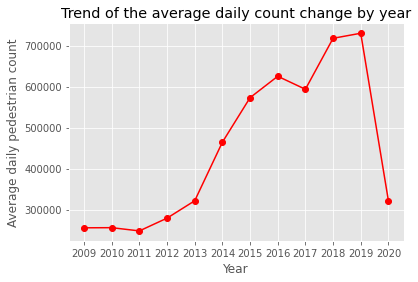

In [17]:
# Group by year and calculate day_count and sum hour
df1_group = df1.groupBy("Year").agg(countDistinct("Year","Month","Mdate").alias("day_count"),sum("Hourly_Counts").alias("total_pedestrian_count"))

# Calculate average daily pedestrian counts and select some columns
df_result = df1_group.select(df1_group.Year, df1_group.total_pedestrian_count, 
                                df1_group.total_pedestrian_count/df1_group.day_count)

# Rename the column name and order by year
df_result = df_result.select(col("Year"),col("total_pedestrian_count"), col("(total_pedestrian_count / day_count)").alias("average_daily_pedestrian_count")).orderBy("Year").toPandas()

def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.plot(x_pos, y, 'ro-', color='red')
    plt.xlabel("Year")
    plt.ylabel("Average daily pedestrian count")
    plt.title("Trend of the average daily count change by year")
    plt.xticks(x_pos, x)
    plt.show()
    
plot_metrics(df_result["Year"],df_result["average_daily_pedestrian_count"])

As for the trend of average daily pedestrian count from 2009 to 2020:

The number increased steadily from 2011 to 2016.
Then, it decreases slightly in 2017, and increase again to meet the peak point in 2019. The reason behind this phenomenon may be the increase in the number of immigrants and refugees, leading to the steady growth of Australia’s total population.

However, the pedestrian count drops sharply in 2020.
This is due to Covid-19 and lockdown in Melbourne, people have to stay at home.


#### 1.2.4.2 Top-10 sensors with the highest average pedestrian counts

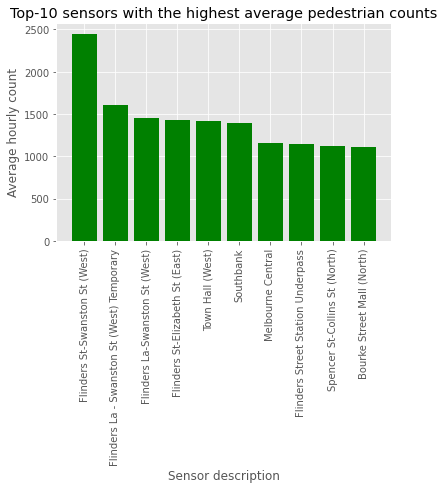

In [18]:
# Group by Sensor ID and calculate total_pedestrian_count and  hours_count
df1_sum = df1.groupby('Sensor_ID').agg(sum("Hourly_Counts").alias("total_pedestrian_count"),count("Hourly_Counts").alias("hours_count"))
# Calculate average_hourly_count
df1_select = df1_sum.select((df1_sum.Sensor_ID).alias("Sensor_ID_1"),(df1_sum.total_pedestrian_count/df1_sum.hours_count).alias("average_hourly_count"))

# Extract sensor_description from df2
df2_desc = df2.select(col("sensor_id"),col("sensor_description")).distinct()

# Join two dataframe
df_join = df1_select.join(df2_desc,df1_select.Sensor_ID_1==df2_desc.sensor_id,how='inner')

# Select relevant columns to print out
df_finish = df_join.select(col("Sensor_ID"),col("sensor_description"),col("average_hourly_count")).sort('average_hourly_count', ascending=False).toPandas()
df = df_finish.head(10)

def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, y, color='green')

    plt.xlabel("Sensor description")
    plt.ylabel("Average hourly count")
    plt.title("Top-10 sensors with the highest average pedestrian counts")
    plt.xticks(x_pos, x, rotation=90)
    plt.show()
    
plot_metrics(df["sensor_description"],df["average_hourly_count"])


In this part, we draw a bar chart to show the Top-10 sensors' names with the highest average pedestrian counts. To be specific, we use sensor description as the x-axis and average pedestrian count as the y-axis.  

From this chart, we can find that they are five sensor description contains a location named "Flinders". So, we can conclude that Flinder street may near the city center or public transport station, which can record higher passenger flow.


# 2 Feature extraction and ML training

## 2.1 Discuss the feature selection and prepare the feature columns

These columns I am planning to use as features:

Year, Month, Mdate, day, and time columns are time objects, which play a significant role in the number of pedestrians. From question 1.2.4.1, we know that the pedestrian count difference in a different time is very obvious, so we have to regard it as a feature.   
-- Month, Day: These columns would be transformed to numeric values and needn't do the OneHotEncoder, because they are order value.  
-- Year, Mdate, Time: These columns needn't do any transfor, because they are ordered value.
    
     
Latitude, longitude are location object. The different location has a different number of pedestrians, so they should be regarded as the features.   
-- Latitude, longitude: needn't do any transformation.   
 

Sensor_id: different sensor_id means different sensor, which will conduct different hourly pedestrian value records, and this value needs do the OneHotEncoder operation.

Hourly_Counts and above_threshold are the labels that we will use our model to predict.


In [19]:
df1_filter = df1.filter(df1["Time"] >= 9 ).filter(df1["Time"] <= 23)
df1_select = df1_filter.select(col("Year"),col("Month"),col("Mdate"),col("Day"),col("Time"),col("Sensor_ID").alias("Sensor_ID_1"),col("Hourly_Counts"),col("above_threshold"))

df_join = df1_select.join(df2,df1_select.Sensor_ID_1==df2.sensor_id,how='inner')

df = df_join.select(col("Year"),col("Month"),col("Mdate"),col("Day"),col("Time"),col("sensor_id"),
                           col("latitude"),col("longitude"),col("Hourly_Counts"),col("above_threshold"))
df.show(3)

+----+--------+-----+------+----+---------+----------+---------+-------------+---------------+
|Year|   Month|Mdate|   Day|Time|sensor_id|  latitude|longitude|Hourly_Counts|above_threshold|
+----+--------+-----+------+----+---------+----------+---------+-------------+---------------+
|2019|November|    1|Friday|  17|       34| -37.81538|144.97415|          300|              0|
|2019|November|    1|Friday|  17|       39|-37.813797|144.96996|          604|              0|
|2019|November|    1|Friday|  17|       37|-37.803104|144.96672|          216|              0|
+----+--------+-----+------+----+---------+----------+---------+-------------+---------------+
only showing top 3 rows



## 2.2 Preparing Spark ML Transformers/Estimators for features, labels and models

### 2.2.1 Create Transformers/Estimators

In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

from itertools import *


In [21]:
# Covert String value into numerical
indexer = StringIndexer(inputCols=['Month','Day'],outputCols=['Month_index','Day_index'])
# encoder = OneHotEncoder(inputCols=['sensor_id','Month_index','Day_index'],outputCols=['sensor_id_vec','Month_vec','Day_vec'])
 # encoder = OneHotEncoder(inputCols=['Month_index','Day_index'],outputCols=['Month_vec','Day_vec'])
#assembler = VectorAssembler(inputCols=['Year','Month_vec','Mdate','Day_vec','Time','sensor_id','latitude','longitude'],outputCol='features')
assembler = VectorAssembler(inputCols=['Year','Month_index','Mdate','Day_index','Time','sensor_id','latitude','longitude'],outputCol='features')
#df=df.withColumnRenamed('above_threshold', 'Tree_label')
#df=df.withColumnRenamed('Hourly_Counts', 'Regression_label')

# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'above_threshold', maxDepth = 5, maxBins = 32)
dt_2 = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'Hourly_Counts', maxDepth = 5, maxBins = 32)
# dtModel =  dt.fit(train)#WRITE CODE : Use the fit method to train the model with the training data you created in Step 4
# dtPredictions = dtModel.transform(test)#WRITE CODE to get predictions from the test data
# # Train a GBT model.
gbt = GBTClassifier(labelCol="above_threshold", featuresCol="features", maxIter=15)
gbt_2 = GBTRegressor(labelCol="Hourly_Counts", featuresCol="features", maxIter=15)

### 2.2.2 Create Pipelines

In [22]:
pipeline = Pipeline(stages=[indexer,assembler])

### 2.2.3 Explain the maxDepth and maxBin

Max_depth: The decision tree model first splits all data sets, and then continues to loop this segmentation process on the sub-data sets. Max_depth can be understood as limiting the number of cycles.   
    
Max_bin: max_bin is controls the maximum number of bins that features will bucketed into. 
A smaller maxbin will result in faster speed, and a larger value will improve accuracy. For better accuracy, you can use a large max_bin.  
In this case, we can use moderate max_depth to improve the speed and higher max_bin to get better accuracy.

## 2.3 Preparing the training data and testing data (4%)

In [23]:
train = df.filter(df["Year"] >= 2014 ).filter(df["Year"] <= 2018)
test = df.filter(df["Year"] == 2019 )

train = pipeline.fit(train).transform(train)["features","above_threshold","Hourly_Counts"]
test = pipeline.fit(test).transform(test)["features","above_threshold","Hourly_Counts"]

train.cache()
test.cache()

DataFrame[features: vector, above_threshold: int, Hourly_Counts: int]

## 2.4 Training and evaluating models (38%)

## Use case 1

### 2.4.1 Perform predictions

In [24]:
# Use the fit method to train the model with the training data you created 
dtModel =  dt.fit(train)
# Get the predictions for the test data
dtPredictions = dtModel.transform(test)

# Use the fit method to train the model with the training data you created 
gbtModel =  gbt.fit(train)
# Get the predictions for the test data
gbtPredictions =  gbtModel.transform(test)

### 2.4.2 Compute the AUC, accuracy, recall and precision

In [25]:
# Create function to calculate accuracy, precision, recall
def compute_metrics(predictions):
    # To calculate accuracy,precision,recall and f1 
    
    TN = predictions.filter('prediction = 0 AND above_threshold = 0').count()
    TP = predictions.filter('prediction = 1 AND above_threshold = 1').count()
    FN = predictions.filter('prediction = 0 AND above_threshold = 1').count()#WRITE CODE to find the False Negative
    FP = predictions.filter('prediction = 1 AND above_threshold = 0').count()#WRITE CODE to find the False Positive
    
    # show confusion matrix
    predictions.groupBy('above_threshold', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TP+TN) / (TP+TN+FP+FN)#WRITE CODE : formula to find accuracy
    precision = TP / (TP + FP)#WRITE CODE : formula to find precision
    recall = TP / (TP + FN)#WRITE CODE : formula to find recall
    f1 = 2 / ((1/recall)+(1/precision))#WRITE CODE : formula to find F1-score
    
    return accuracy,precision,recall,f1    



In [26]:
# Create function to calculate auc
def auc_cal_tr(dtPredictions):
    # Evaluate model Decision Tree
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    #auc_dt = evaluator.evaluate(dtPredictions)
    auc_dtPredictions=dtPredictions.withColumnRenamed('above_threshold','label')
    auc_dt = evaluator.evaluate(auc_dtPredictions)
    return auc_dt

In [27]:
# Print out the result for Decision tree
print("As for Decision Tree model :")
dt_acc = compute_metrics(dtPredictions)
print("The AUC,is " + str(auc_cal_tr(dtPredictions)))
print("Accuracy is "+ str(dt_acc[0]) + " \nRecall is " + str(dt_acc[2]) + "\nPrecision is " + str(dt_acc[1]) + "\n" )

# Print out the result for GBT model
print("As for GBT Regressor Model :")
dt_acc = compute_metrics(gbtPredictions)
print("The AUC,is " + str(auc_cal_tr(gbtPredictions)))
print("Accuracy is "+ str(dt_acc[0]) + " \nRecall is " + str(dt_acc[2]) + "\nPrecision is " + str(dt_acc[1]) + "\n" )



As for Decision Tree model :
+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 12295|
|              0|       0.0|246834|
|              1|       1.0| 18746|
|              0|       1.0|  7657|
+---------------+----------+------+

The AUC,is 0.6451891999055928
Accuracy is 0.9301234187411569 
Recall is 0.6039109564769176
Precision is 0.7099950763170851

As for GBT Regressor Model :
+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 13241|
|              0|       0.0|249001|
|              1|       1.0| 17800|
|              0|       1.0|  5490|
+---------------+----------+------+

The AUC,is 0.9408141453966467
Accuracy is 0.9343996469747698 
Recall is 0.5734351341773783
Precision is 0.764276513525118



In order to give the performers good recommendations while reducing the chance of falsely recommending a location, precision is more proper for measuring the model performance on predicting above-threshold events.  
To be specific, precision is TP / (TP + FP). (TP means prediction = 1 AND above_threshold = 1; FP means prediction = 1 AND above_threshold = 0). In this way, we use correct above-threshold count value as the numerator and all above-threshold count value that is predicted by this model as the denominator to get a number.   
This number presents the model performance in predicting above-threshold events. The larger the precision, the higher the accuracy rate of being classified into above-threshold. Choosing a model with a large precision value can reduce the chance of falsely recommending a location.

The precision of Decision-Tree model is 0.71 and the precision of Gradient-Boosted-Tree model is 0.7643, which is higher than the previous one.  
As a result, Gradient Boosted Tree model is the better model.


### 2.4.3 Leaf node

##### 1 - Leaf node splitting criteria

In [28]:
print(dtModel.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_4a4fc38c705c, depth=5, numNodes=29, numClasses=2, numFeatures=8
  If (feature 5 <= 5.5)
   If (feature 4 <= 18.5)
    If (feature 4 <= 11.5)
     Predict: 0.0
    Else (feature 4 > 11.5)
     If (feature 6 <= -37.81868553161621)
      If (feature 0 <= 2014.5)
       Predict: 0.0
      Else (feature 0 > 2014.5)
       Predict: 1.0
     Else (feature 6 > -37.81868553161621)
      Predict: 1.0
   Else (feature 4 > 18.5)
    If (feature 3 in {1.0,3.0,4.0,5.0,6.0})
     If (feature 4 <= 19.5)
      If (feature 6 <= -37.813472747802734)
       Predict: 0.0
      Else (feature 6 > -37.813472747802734)
       Predict: 1.0
     Else (feature 4 > 19.5)
      Predict: 0.0
    Else (feature 3 not in {1.0,3.0,4.0,5.0,6.0})
     If (feature 4 <= 21.5)
      If (feature 6 <= -37.813472747802734)
       Predict: 0.0
      Else (feature 6 > -37.813472747802734)
       Predict: 1.0
     Else (feature 4 > 21.5)
      Predict: 0.0
  Else (feature

In [29]:
from itertools import *
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*dtPredictions
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

attrs

[(0, 'Year'),
 (1, 'Month_index'),
 (2, 'Mdate'),
 (3, 'Day_index'),
 (4, 'Time'),
 (5, 'sensor_id'),
 (6, 'latitude'),
 (7, 'longitude')]

In this part, we can use attrs list to understand the the leaf node splitting criteria.  

For instance, in the first part of the leaf node splitting criteria:  

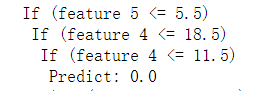  

 It can be de translated into: When sensor_id <= 5.5 and time <= 11.5, the predict value is 0.

##### 2 - Top-3 features

In [30]:
list = [(name, dtModel.featureImportances[idx])
 for idx, name in attrs
 if dtModel.featureImportances[idx]]

In [31]:
list

[('Year', 0.0033494520662663116),
 ('Day_index', 0.008228279340931505),
 ('Time', 0.34625850933332325),
 ('sensor_id', 0.2916395766347699),
 ('latitude', 0.11843311150407206),
 ('longitude', 0.23209107112063695)]

In [32]:
df = pd.DataFrame(list).set_index([0])

df.columns = ['importance']
df = df.sort_values(by=['importance'],ascending=False).iloc[0:3].squeeze()

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1502: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='importance'>

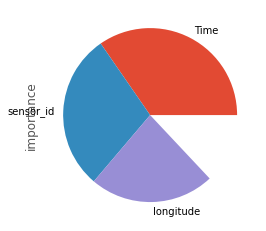

In [33]:
df.plot.pie()

From this pie chart, we know that sensor_id is the most important feature, which contributes 42.36% of the predicted results.  
The next one is the Time feature, which contributes 31.71% of the predicted results.   
Also, longitude plays a significant role in the final result, which contributes around 12.4%.

### 2.4.4 Suggestion

#### Suggestion 1

In order to improve the models, more columns will be used as features to create the ML model. To be specific, the previous hourly count can be added to the feature, which can improve the accuracy of the models. One-step time-series prediction means we need to regard the previous hour pedestrian count as a feature to predict the next hour pedestrian count. So this value should be used, and we needn't do any transform.

To get the previous result as a new column, we need to join the data frame 1 with itself to create a new data frame and select the relevant column.  


Implement it with code snippets: 

In [34]:
    #Select some relevant column
#df_select = df1.select(col("Date_Time"),col("Year"),col("Month"),col("Mdate"),col("Day"),col("Time"),col("Sensor_ID").alias("Sensor_ID_1"),col("Hourly_Counts"),col("above_threshold"))
    # df_select = df_select.filter(df_select["Time"] >= 8 ).filter(df_select["Time"] <= 23)


#df_select_1 = df1.withColumn('Date_Time_1', df_select.Date_Time + F.expr('INTERVAL 1 HOURS'))
#df_select_1 = df_select_1.select(col('Date_Time_1'),col("sensor_id"),col('Hourly_Counts').alias("Previous_Hourly_Counts"))

    #Join this two DF and filter with time
#df_join = df_select.join(df_select_1,(df_select.Date_Time==df_select_1.Date_Time_1) & (df_select.Sensor_ID_1==df_select_1.sensor_id),how='inner').sort('Date_Time')
#df_join = df_join.select(col("Year"),col("Month"),col("Mdate"),col("Day"),col("Time"),col("Sensor_ID_1"),
#                         col("Previous_Hourly_Counts"),col("Hourly_Counts"),col("above_threshold"))

#df_join = df_join.join(df2,df_join.Sensor_ID_1==df2.sensor_id,how='inner')


#df = df_join.select(col("Year"),col("Month"),col("Mdate"),col("Day"),col("Time"),col("Sensor_ID"),
#                    col("latitude"),col("longitude"),col("Previous_Hourly_Counts"),col("Hourly_Counts"),col("above_threshold"))

#df = df.filter(df["Time"] >= 9 ).filter(df["Time"] <= 23)

#### Suggestion 2

In order to improve the models, a new classification method will be used to create an ML model. To be specific, a Multilayer perceptron classifier can be used in this use case. Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network and consists of multiple layers of nodes.   

Implement it with code snippets: 

In [35]:
#from pyspark.ml.classification import MultilayerPerceptronClassifier
#trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
    # train the model
#model = trainer.fit(train)

    # compute accuracy on the test set
#result = model.transform(test)

## Use case 2
### 2.4.5 Perform predictions

In [36]:
# Use the fit method to train the model with the training data you created 
dtModel_2 =  dt_2.fit(train)
# Get the predictions for the test data
dtPredictions_2 = dtModel_2.transform(test)

# Use the fit method to train the model with the training data you created 
gbtModel_2 =  gbt_2.fit(train)
# Get the predictions for the test data
gbtPredictions_2 =  gbtModel_2.transform(test)

### 2.4.6 Perform predictions

In [37]:
from pyspark.ml.evaluation import RegressionEvaluator


In [38]:
# Calculate the value about RMSE and R2
def compute_rmse_rs(predictions):
    rmse_evaluator = RegressionEvaluator(labelCol="Hourly_Counts", metricName="rmse")
    r2_evaluator = RegressionEvaluator(labelCol="Hourly_Counts", metricName="r2")
    
    RMSE = rmse_evaluator.evaluate(predictions)
    R2 = r2_evaluator.evaluate(predictions)
    
    return RMSE,R2


In [39]:
dtModel_result = compute_rmse_rs(dtPredictions_2)
gbtModel_result = compute_rmse_rs(gbtPredictions_2)

print("Decision Tree Regressor Model:" + "\n" + "Root Mean Squared Error = " + str(dtModel_result[0]) + "\n" + "R-squared = " + str(dtModel_result[1])+ "\n")

print("GBT Regressor Model:" + "\n" + "Root Mean Squared Error = " + str(gbtModel_result[0]) + "\n" + "R-squared = " + str(gbtModel_result[1]))


Decision Tree Regressor Model:
Root Mean Squared Error = 621.2521333657949
R-squared = 0.4942607077022825

GBT Regressor Model:
Root Mean Squared Error = 533.3839670465554
R-squared = 0.6272043599346241


Based on the Root Mean Squared Error and R-squared, GBT Regressor Model has higher R-squared and lower Root Mean Squared Error, which means the fitted regression equation is better.   
In summary, we should use GBT Regressor Model.

# 3. Knowledge sharing (6%)

### 3.1 Jobs count

In [40]:
customer_df = spark.createDataFrame([
(0,19,15,39),
(0,21,15,81),
(1,20,16,6),
(1,23,16,77),
(1,31,17,40),
(1,22,17,76),
(1,35,18,6),
(1,23,18,94),
(0,64,19,3),
(1,30,19,72),
(0,67,19,14),
(1,35,19,99),
(1,58,20,15)],
['gender', 'age', 'annual_income', 'spending_score'])

assembler = VectorAssembler(
inputCols=['gender', 'age', 'annual_income', 'spending_score'],
outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(customer_df))

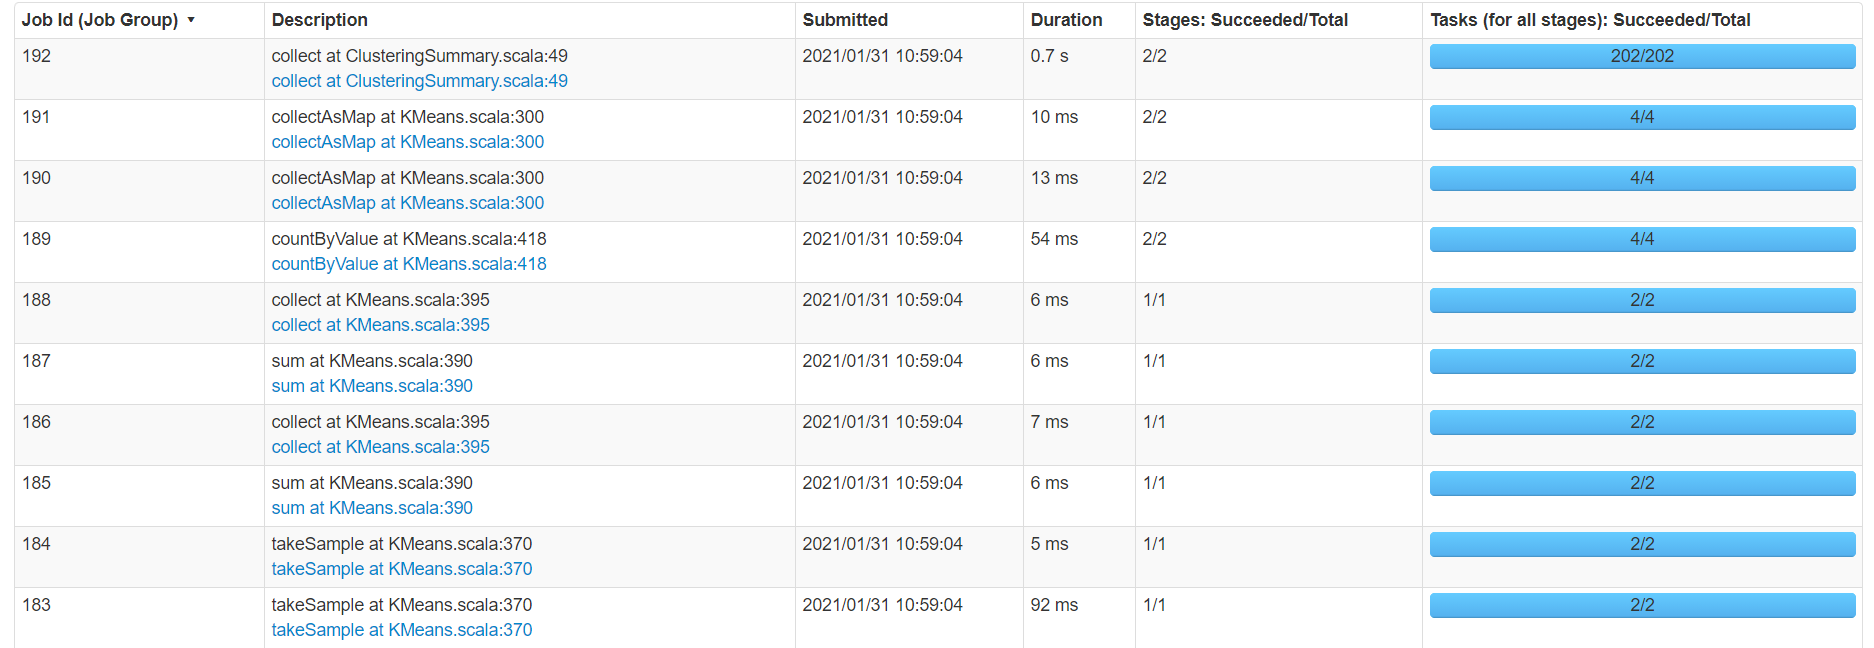

10 jobs are observed when training the KMeans clustering model following the code below.

### 3.2 Parallelism

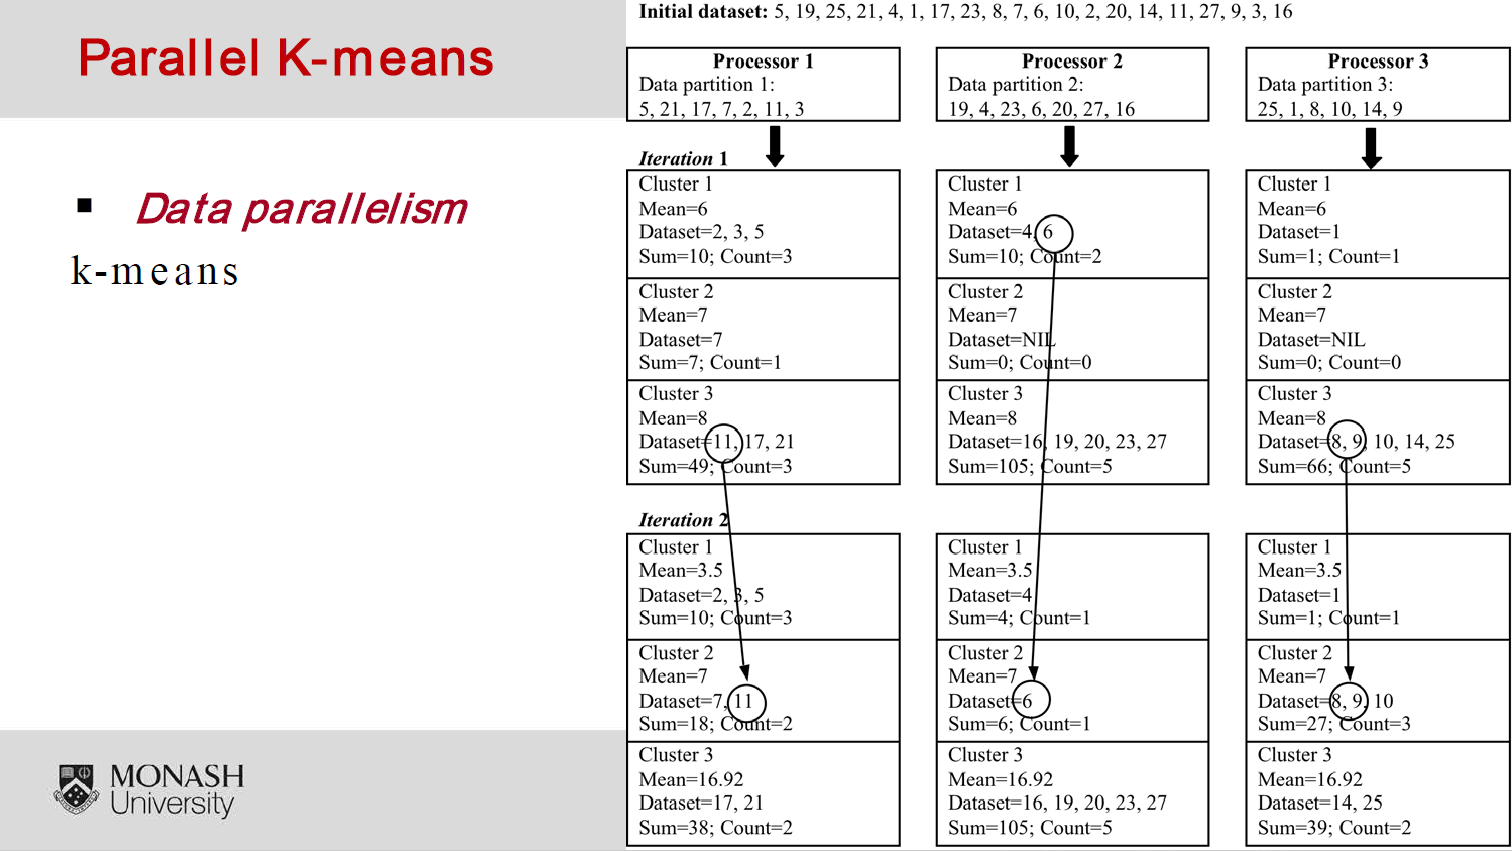

From Spark UI, we find that Spark jobs contain the sum and count process, and collect at ClusteringSummary to get the final result, which is the same as the k-mean data parallelism process.   

As a result, data parallelism is being adopted in the implementation of KMeans clustering in Spark.
